<a href="https://colab.research.google.com/github/sanjaykumars24bai145-droid/credit-card-fraud-detection-/blob/main/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Loaded Successfully

   TransactionID             TransactionDate   Amount  MerchantID  \
0              1  2024-04-03 14:15:35.462794  4189.27         688   
1              2  2024-03-19 13:20:35.462824  2659.71         109   
2              3  2024-01-08 10:08:35.462834   784.00         394   
3              4  2024-04-13 23:50:35.462850  3514.40         944   
4              5  2024-07-12 18:51:35.462858   369.07         475   

  TransactionType      Location  IsFraud  
0          refund   San Antonio        0  
1          refund        Dallas        0  
2        purchase      New York        0  
3        purchase  Philadelphia        0  
4        purchase       Phoenix        0   

Fraud column detected: IsFraud

Final Fraud Label Distribution

Fraud_Label
0    99000
1     1000
Name: count, dtype: int64

Model Training Completed

Model Performance Results

Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
ROC AUC  : 1.0

Classification Report

              precision    recall 

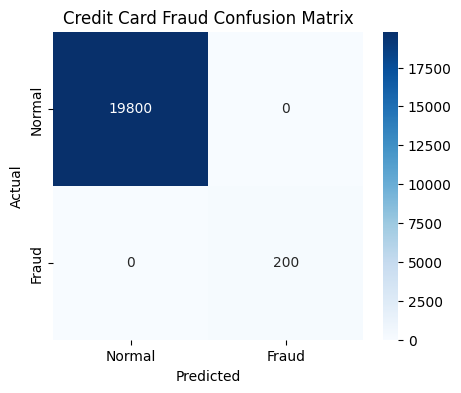

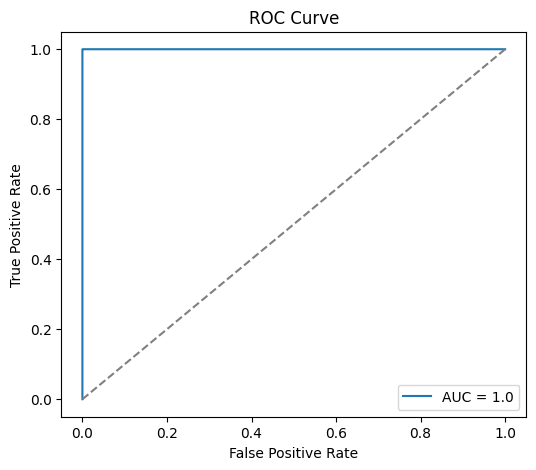

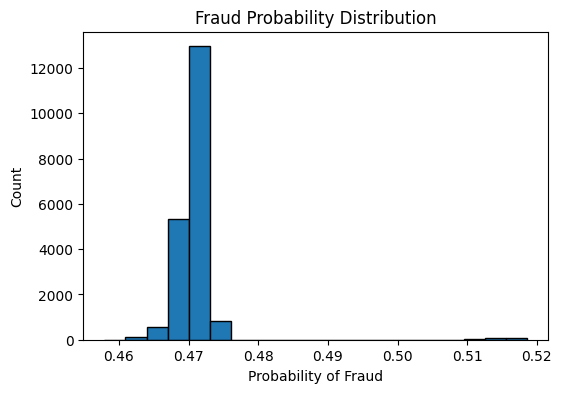

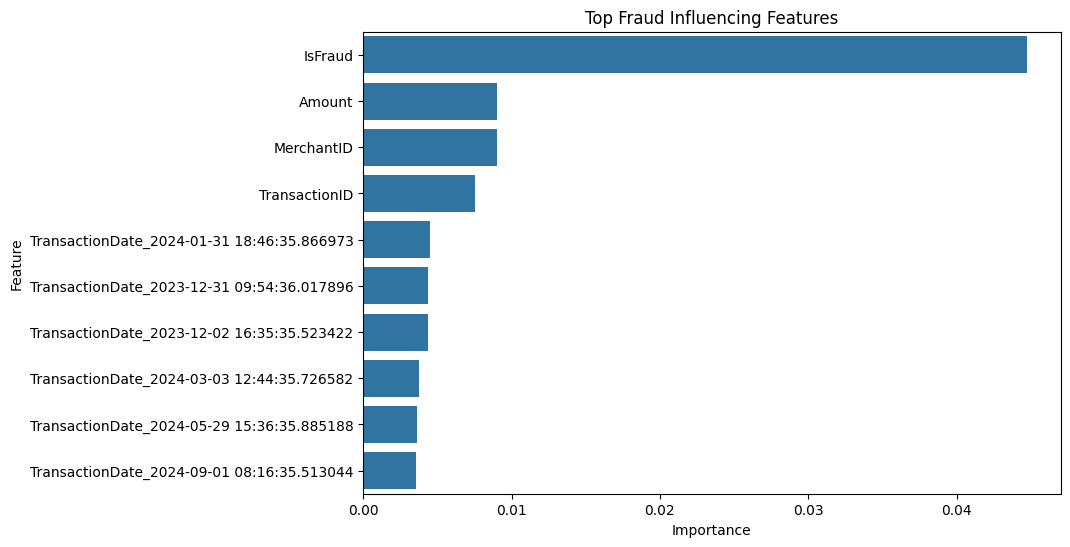


Top 10 Fraud Detection Features

                                          Feature  Importance
3                                         IsFraud    0.044767
1                                          Amount    0.009010
2                                      MerchantID    0.009001
0                                   TransactionID    0.007529
22253  TransactionDate_2024-01-31 18:46:35.866973    0.004473
15549  TransactionDate_2023-12-31 09:54:36.017896    0.004400
9147   TransactionDate_2023-12-02 16:35:35.523422    0.004354
29142  TransactionDate_2024-03-03 12:44:35.726582    0.003787
48323  TransactionDate_2024-05-29 15:36:35.885188    0.003620
68962  TransactionDate_2024-09-01 08:16:35.513044    0.003590

Sample Transaction Analysis
Prediction: Normal Transaction
Risk Probability: 0.4723


In [2]:
 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

df = pd.read_csv("credit_card_fraud_dataset.csv")
df.columns = df.columns.str.strip()

print("Dataset Loaded Successfully\n")
print(df.head(), "\n")

possible_labels = ["Class", "Fraud", "label", "isFraud", "IsFraud", "target", "fraud_flag", "Outcome", "Y"]
label_found = False

for col in possible_labels:
    if col in df.columns:
        df["Fraud_Label"] = df[col]
        print("Fraud column detected:", col)
        label_found = True
        break

if not label_found:
    print("No fraud label found in dataset")
    print("Available Columns:", df.columns)
    raise Exception("Fraud column missing. Add a column named Class, Fraud, or IsFraud")

df = df.dropna(subset=["Fraud_Label"])
df["Fraud_Label"] = pd.to_numeric(df["Fraud_Label"], errors="coerce")
df = df.dropna(subset=["Fraud_Label"])
df["Fraud_Label"] = df["Fraud_Label"].astype(int)

print("\nFinal Fraud Label Distribution\n")
print(df["Fraud_Label"].value_counts())

X = df.drop("Fraud_Label", axis=1)
y = df["Fraud_Label"]

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(
        n_estimators=200,
        max_depth=12,
        class_weight="balanced",
        random_state=42
    ))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

model.fit(X_train, y_train)
print("\nModel Training Completed\n")

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Model Performance Results\n")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
print("ROC AUC  :", roc_auc_score(y_test, y_prob))

print("\nClassification Report\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Fraud"],
            yticklabels=["Normal","Fraud"])
plt.title("Credit Card Fraud Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="AUC = " + str(round(auc(fpr, tpr), 2)))
plt.plot([0,1], [0,1], "--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=20, edgecolor="black")
plt.title("Fraud Probability Distribution")
plt.xlabel("Probability of Fraud")
plt.ylabel("Count")
plt.show()

rf = model.named_steps["classifier"]

if len(categorical_cols) > 0:
    ohe = model.named_steps["preprocess"].named_transformers_["cat"]
    encoded_cat = ohe.get_feature_names_out(categorical_cols)
    final_features = list(numeric_cols) + list(encoded_cat)
else:
    final_features = list(numeric_cols)

feature_imp = pd.DataFrame({
    "Feature": final_features,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(9,6))
sns.barplot(x="Importance", y="Feature", data=feature_imp.head(10))
plt.title("Top Fraud Influencing Features")
plt.show()

print("\nTop 10 Fraud Detection Features\n")
print(feature_imp.head(10))

sample = pd.DataFrame([X.iloc[0].to_dict()])
prediction = model.predict(sample)[0]
probability = model.predict_proba(sample)[0][1]

print("\nSample Transaction Analysis")
print("Prediction:", "FRAUD DETECTED" if prediction == 1 else "Normal Transaction")
print("Risk Probability:", round(probability, 4))
